Saved files:
- Map_RSS_Coarse_with_values.png
- Map_RSS_Fine_with_values.png
- Heatmap_RSS_Coarse.png
- Heatmap_RSS_Fine.png
- RSS_Maps_PointAndHeat_2x2.png


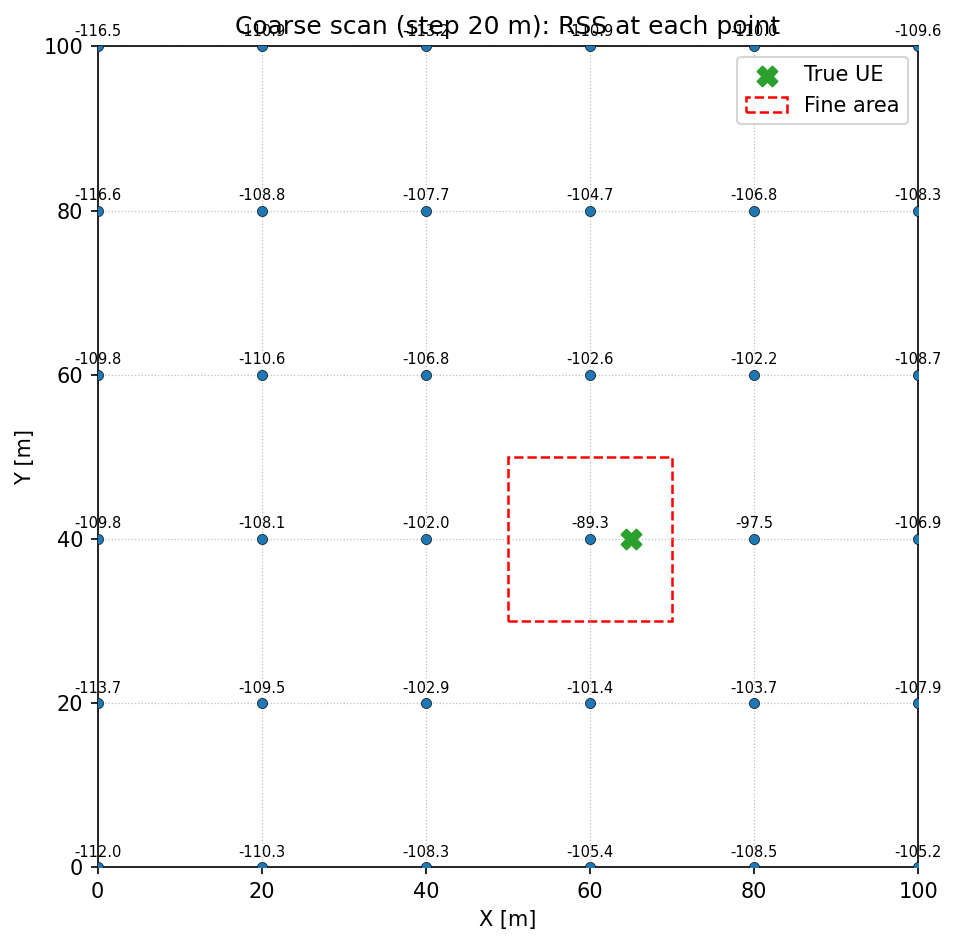

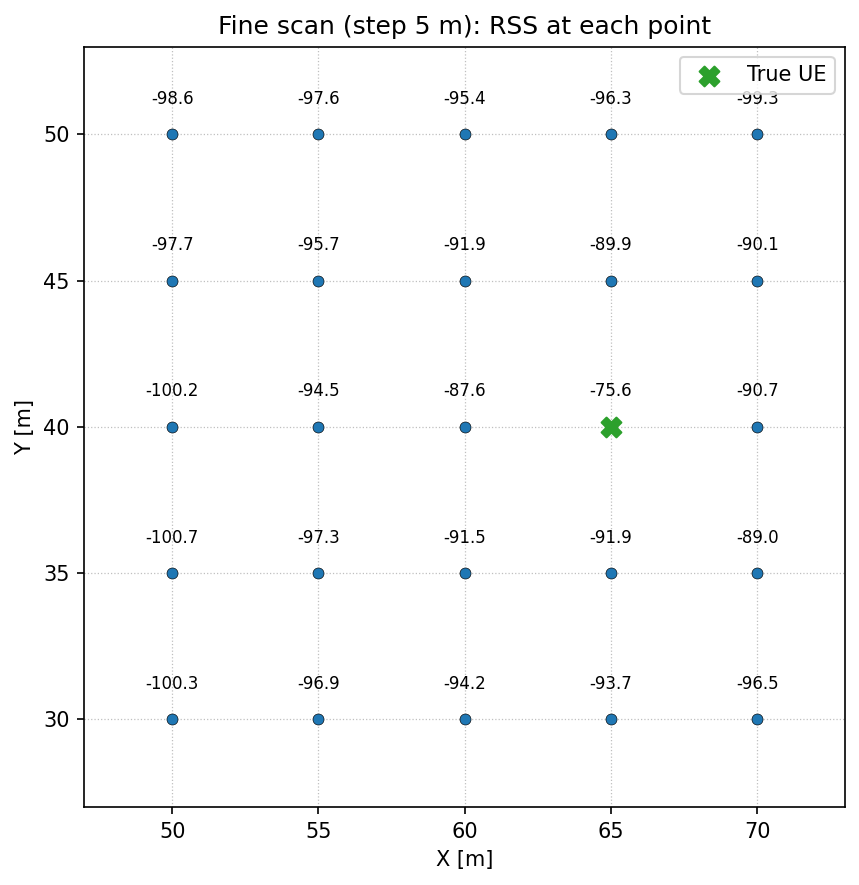

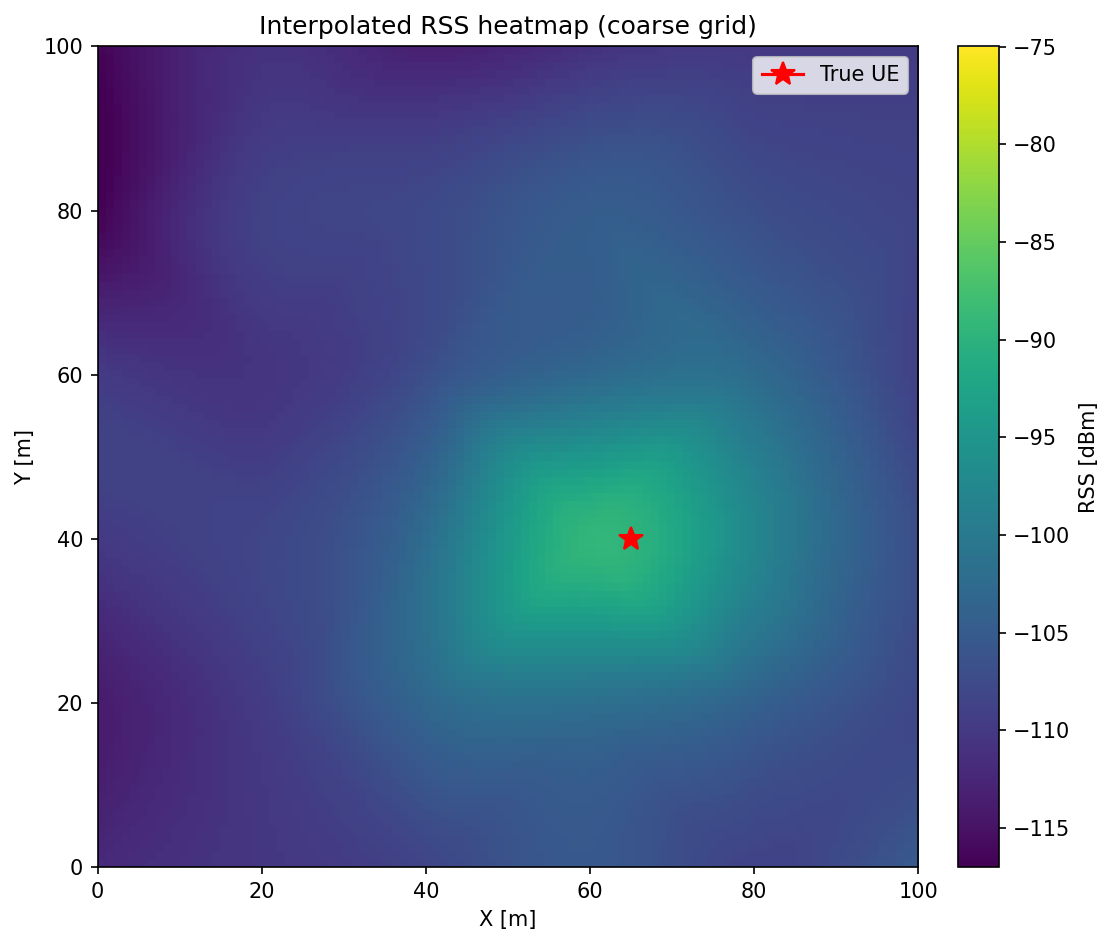

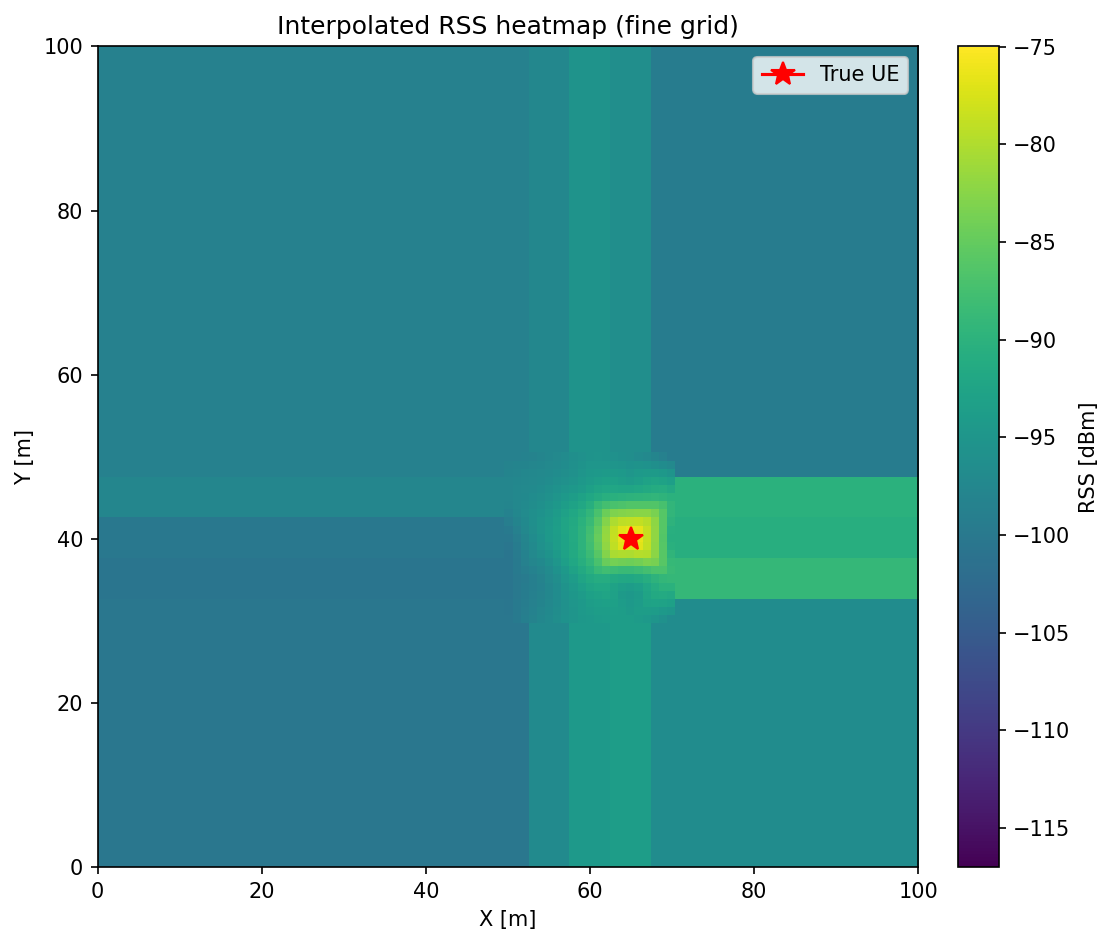

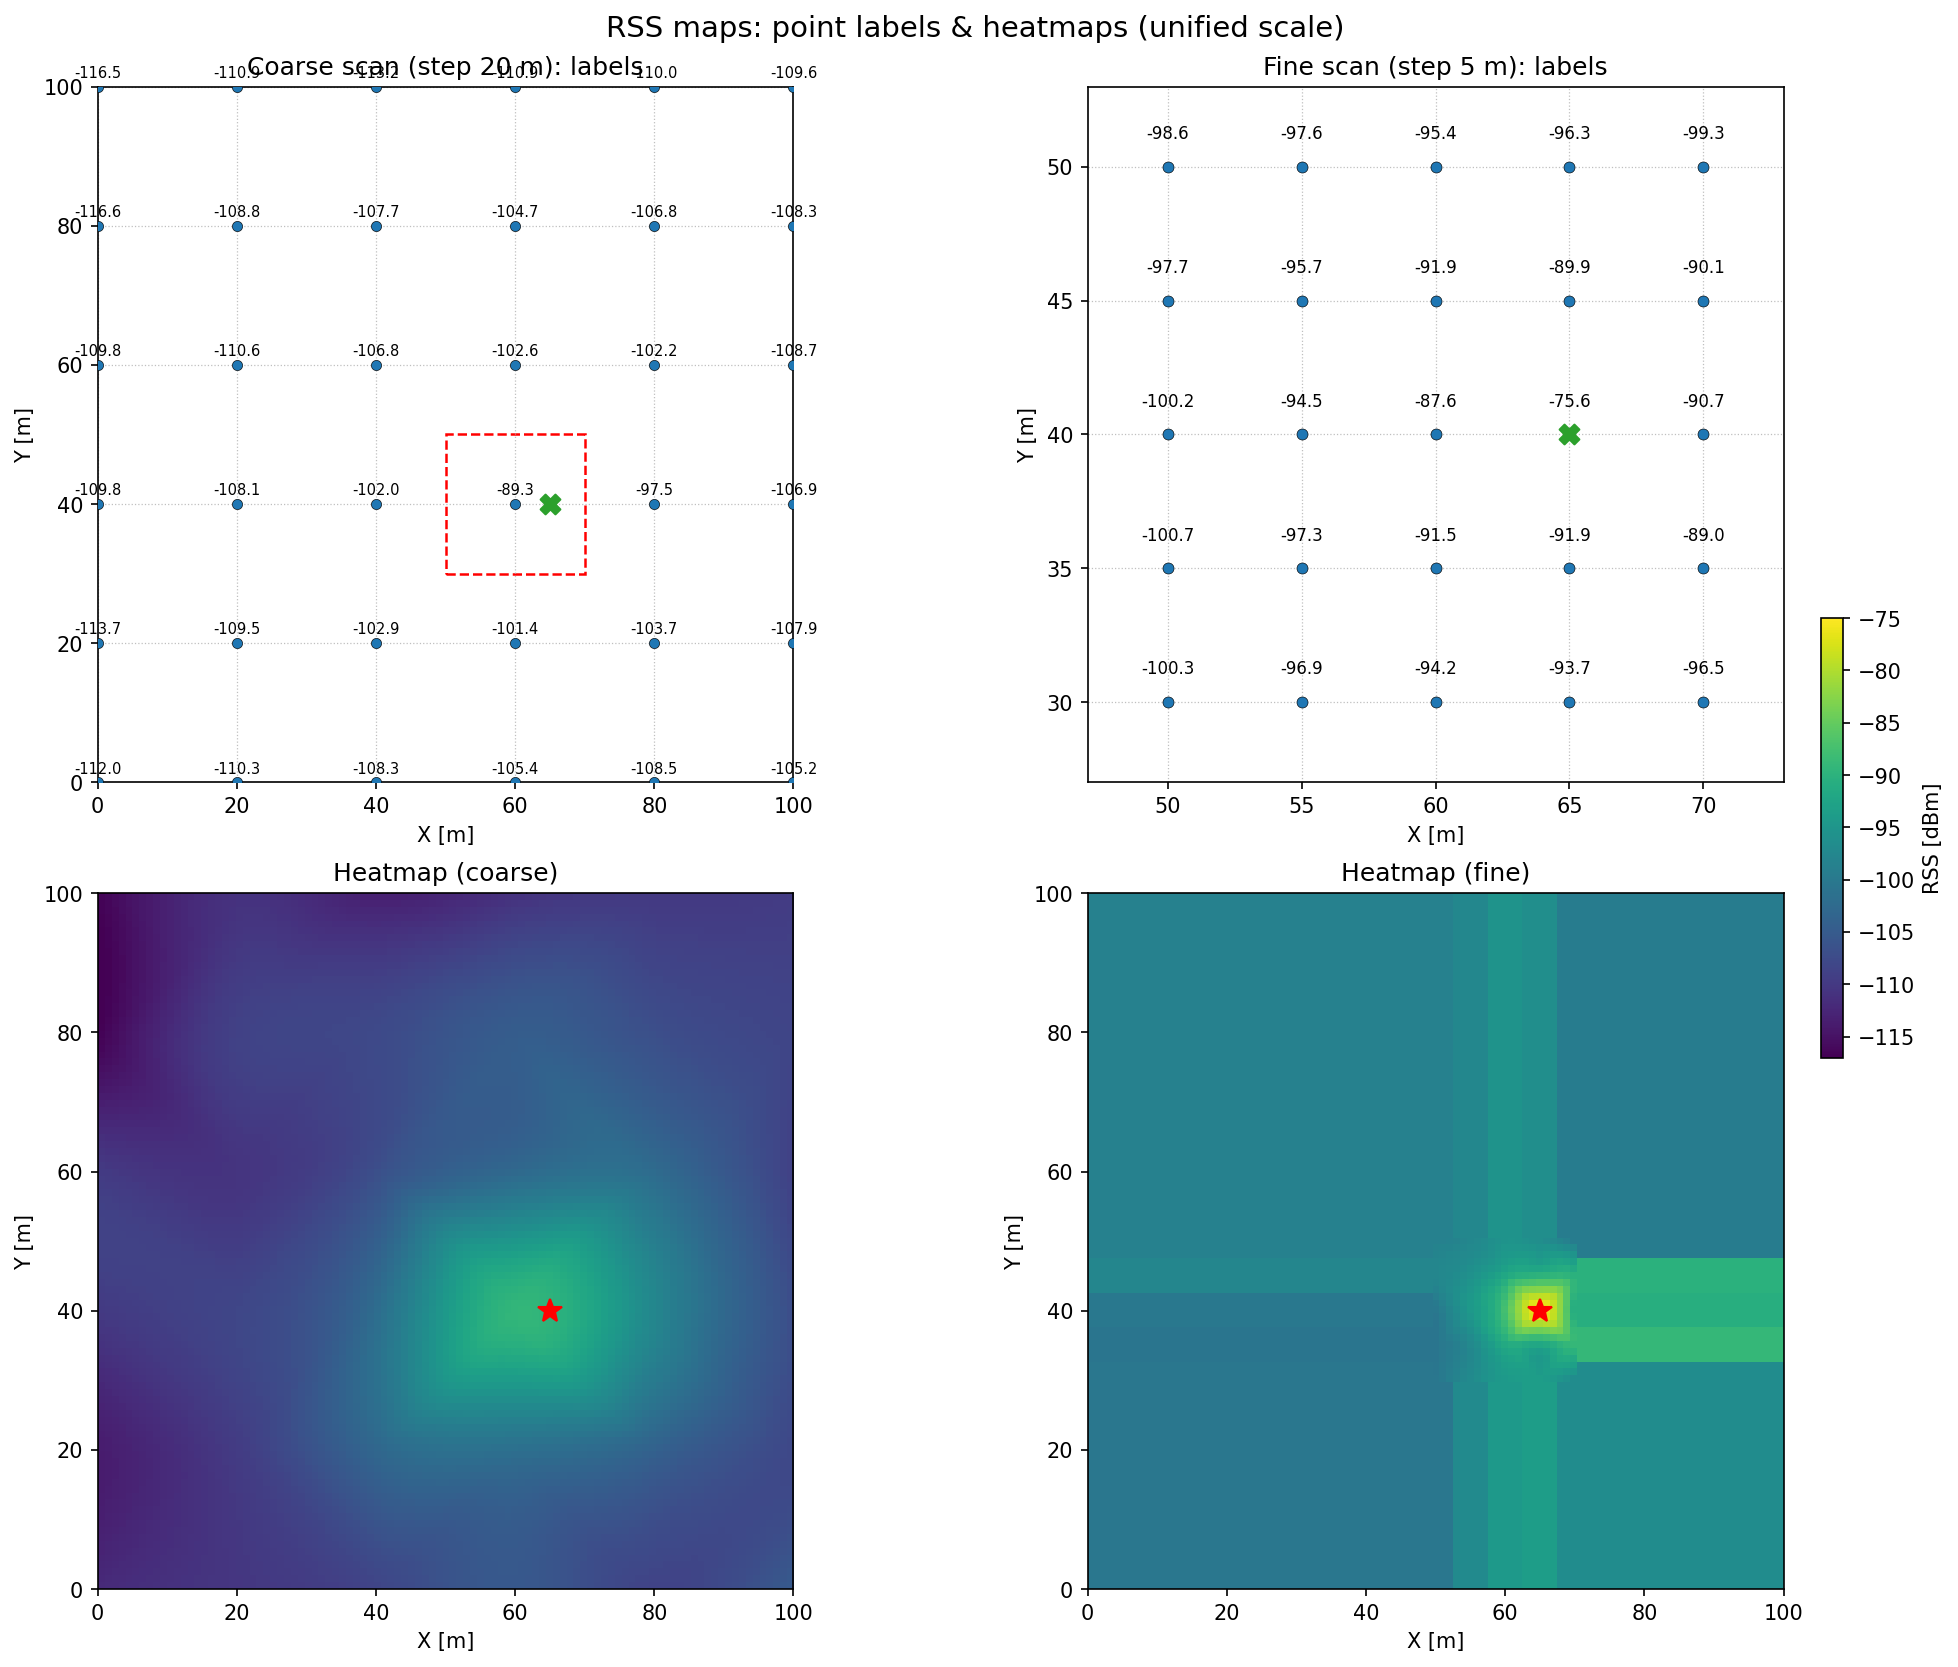

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.spatial.distance import euclidean
from scipy.interpolate import griddata

rng = np.random.default_rng(42)

# PARAMETERS
area_size   = 100
coarse_step = 20
fine_step   = 5
true_ue_pos = np.array([65, 40])

# path-loss model
rss0          = -75
d0            = 1.0
n             = 2.0
shadowing_std = 2.0

def simulate_rss(pos, ue_pos):
    d = euclidean(pos, ue_pos)
    d = max(d, d0)
    path_loss = 10 * n * np.log10(d / d0)
    shadowing = rng.normal(0, shadowing_std)
    return rss0 - path_loss + shadowing

def plot_points_with_labels(ax, positions, values, title,
                            point_kwargs=None, text_kwargs=None,
                            xlim=(0, None), ylim=(0, None)):
    positions = np.asarray(positions)
    values = np.asarray(values)
    if point_kwargs is None:
        point_kwargs = dict(s=24, edgecolor='k', linewidth=0.3, zorder=3)
    if text_kwargs is None:
        text_kwargs = dict(fontsize=7, ha='center', va='bottom')

    ax.scatter(positions[:, 0], positions[:, 1], c='tab:blue', **point_kwargs)
    for (x, y), v in zip(positions, values):
        ax.text(x, y + 0.9, f'{v:.1f}', **text_kwargs)

    ax.set_title(title)
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_aspect('equal', 'box')
    if xlim[1] is None: xlim = (0, area_size)
    if ylim[1] is None: ylim = (0, area_size)
    ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    ax.grid(True, linestyle=':', linewidth=0.6, alpha=0.8)

def interpolate_to_grid(positions, values, step=1.0):
    """Интерполяция RSS на равномерную сетку для heatmap."""
    gx = np.arange(0, area_size + step, step)
    gy = np.arange(0, area_size + step, step)
    GX, GY = np.meshgrid(gx, gy)
    Z = griddata(positions, values, (GX, GY), method='cubic')
    if np.isnan(Z).any():
        Z_lin = griddata(positions, values, (GX, GY), method='linear')
        Z = np.where(np.isnan(Z), Z_lin, Z)
    if np.isnan(Z).any():
        Z_nn = griddata(positions, values, (GX, GY), method='nearest')
        Z = np.where(np.isnan(Z), Z_nn, Z)
    return GX, GY, Z

def plot_heatmap(ax, Z, title, norm):
    im = ax.imshow(Z, origin='lower', extent=[0, area_size, 0, area_size],
                   cmap='viridis', norm=norm, interpolation='nearest', aspect='equal')
    ax.set_title(title)
    ax.set_xlabel('X [m]'); ax.set_ylabel('Y [m]')
    ax.plot(true_ue_pos[0], true_ue_pos[1], marker='*', markersize=12, color='red', label='True UE')
    ax.legend(loc='upper right', frameon=True)
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('RSS [dBm]')
    return im

x_coarse = np.arange(0, area_size + 1, coarse_step)
y_coarse = np.arange(0, area_size + 1, coarse_step)
coarse_positions = np.array([(x, y) for x in x_coarse for y in y_coarse])
rss_coarse = np.array([simulate_rss(pos, true_ue_pos) for pos in coarse_positions])
rss_coarse_r = np.round(rss_coarse, 1)

max_rss_index = np.argmax(rss_coarse)
warm_center = coarse_positions[max_rss_index]
rect_x0, rect_y0 = warm_center[0] - 10, warm_center[1] - 10
rect_w = rect_h = 20

x_fine = np.arange(warm_center[0] - 10, warm_center[0] + 10 + 1e-9, fine_step)
y_fine = np.arange(warm_center[1] - 10, warm_center[1] + 10 + 1e-9, fine_step)
x_fine = x_fine[(x_fine >= 0) & (x_fine <= area_size)]
y_fine = y_fine[(y_fine >= 0) & (y_fine <= area_size)]
fine_positions = np.array([(x, y) for x in x_fine for y in y_fine])
rss_fine = np.array([simulate_rss(pos, true_ue_pos) for pos in fine_positions])
rss_fine_r = np.round(rss_fine, 1)

pd.DataFrame({'X [m]': coarse_positions[:,0], 'Y [m]': coarse_positions[:,1], 'RSS [dBm]': rss_coarse_r}).to_csv('Table_3_1_RSS_Coarse_Scan.csv', index=False)
pd.DataFrame({'X [m]': fine_positions[:,0], 'Y [m]': fine_positions[:,1], 'RSS [dBm]': rss_fine_r}).to_csv('Table_3_2_RSS_Fine_Scan.csv', index=False)

#Point maps with label
fig1, ax1 = plt.subplots(figsize=(7.6, 6.4), dpi=150)
plot_points_with_labels(ax1, coarse_positions, rss_coarse_r,
                        title=f'Coarse scan (step {coarse_step} m): RSS at each point')
ax1.scatter([true_ue_pos[0]],[true_ue_pos[1]], marker='X', s=90, color='tab:green', zorder=4, label='True UE')
ax1.add_patch(plt.Rectangle((rect_x0, rect_y0), rect_w, rect_h, fill=False, linestyle='--',
                            linewidth=1.2, color='red', label='Fine area'))
ax1.legend(loc='upper right', frameon=True)
fig1.tight_layout(); fig1.savefig('Map_RSS_Coarse_with_values.png', dpi=300)

fig2, ax2 = plt.subplots(figsize=(6.8, 6.0), dpi=150)
plot_points_with_labels(ax2, fine_positions, rss_fine_r,
                        title=f'Fine scan (step {fine_step} m): RSS at each point',
                        xlim=(rect_x0-3, rect_x0+rect_w+3),
                        ylim=(rect_y0-3, rect_y0+rect_h+3),
                        point_kwargs=dict(s=28, edgecolor='k', linewidth=0.3, zorder=3),
                        text_kwargs=dict(fontsize=8, ha='center', va='bottom'))
ax2.scatter([true_ue_pos[0]],[true_ue_pos[1]], marker='X', s=90, color='tab:green', zorder=4, label='True UE')
ax2.legend(loc='upper right', frameon=True)
fig2.tight_layout(); fig2.savefig('Map_RSS_Fine_with_values.png', dpi=300)

#Heatmaps (interpolated) with unified color scale
GXc, GYc, Zc = interpolate_to_grid(coarse_positions, rss_coarse_r, step=1.0)
GXf, GYf, Zf = interpolate_to_grid(fine_positions,   rss_fine_r,   step=1.0)

all_rss = np.concatenate([rss_coarse_r, rss_fine_r])
norm = Normalize(vmin=np.floor(all_rss.min()), vmax=np.ceil(all_rss.max()))

fig3, ax3 = plt.subplots(figsize=(7.6, 6.4), dpi=150)
plot_heatmap(ax3, Zc, title='Interpolated RSS heatmap (coarse grid)', norm=norm)
fig3.tight_layout(); fig3.savefig('Heatmap_RSS_Coarse.png', dpi=300)

fig4, ax4 = plt.subplots(figsize=(7.6, 6.4), dpi=150)
plot_heatmap(ax4, Zf, title='Interpolated RSS heatmap (fine grid)', norm=norm)
fig4.tight_layout(); fig4.savefig('Heatmap_RSS_Fine.png', dpi=300)

fig5, axs = plt.subplots(2, 2, figsize=(13, 11), dpi=150, constrained_layout=True)

plot_points_with_labels(axs[0,0], coarse_positions, rss_coarse_r,
                        title=f'Coarse scan (step {coarse_step} m): labels')
axs[0,0].scatter([true_ue_pos[0]],[true_ue_pos[1]], marker='X', s=90, color='tab:green', zorder=4)
axs[0,0].add_patch(plt.Rectangle((rect_x0, rect_y0), rect_w, rect_h, fill=False, linestyle='--',
                                 linewidth=1.2, color='red'))

plot_points_with_labels(axs[0,1], fine_positions, rss_fine_r,
                        title=f'Fine scan (step {fine_step} m): labels',
                        xlim=(rect_x0-3, rect_x0+rect_w+3),
                        ylim=(rect_y0-3, rect_y0+rect_h+3),
                        point_kwargs=dict(s=28, edgecolor='k', linewidth=0.3, zorder=3),
                        text_kwargs=dict(fontsize=8, ha='center', va='bottom'))
axs[0,1].scatter([true_ue_pos[0]],[true_ue_pos[1]], marker='X', s=90, color='tab:green', zorder=4)

im_c = axs[1,0].imshow(Zc, origin='lower', extent=[0, area_size, 0, area_size],
                       cmap='viridis', norm=norm, interpolation='nearest', aspect='equal')
axs[1,0].set_title('Heatmap (coarse)'); axs[1,0].set_xlabel('X [m]'); axs[1,0].set_ylabel('Y [m]')
axs[1,0].plot(true_ue_pos[0], true_ue_pos[1], marker='*', markersize=12, color='red')

im_f = axs[1,1].imshow(Zf, origin='lower', extent=[0, area_size, 0, area_size],
                       cmap='viridis', norm=norm, interpolation='nearest', aspect='equal')
axs[1,1].set_title('Heatmap (fine)'); axs[1,1].set_xlabel('X [m]'); axs[1,1].set_ylabel('Y [m]')
axs[1,1].plot(true_ue_pos[0], true_ue_pos[1], marker='*', markersize=12, color='red')

cbar = fig5.colorbar(im_f, ax=axs[:,1], fraction=0.025, pad=0.02)
cbar.set_label('RSS [dBm]')
fig5.suptitle('RSS maps: point labels & heatmaps (unified scale)', fontsize=14)
fig5.savefig('RSS_Maps_PointAndHeat_2x2.png', dpi=300)

print("Saved files:")
print("- Map_RSS_Coarse_with_values.png")
print("- Map_RSS_Fine_with_values.png")
print("- Heatmap_RSS_Coarse.png")
print("- Heatmap_RSS_Fine.png")
print("- RSS_Maps_PointAndHeat_2x2.png")
